# Analisis Pengujian Sistem Hand Tracking

Notebook ini digunakan untuk menganalisis hasil pengujian sistem hand tracking pada berbagai skenario, termasuk variasi jarak, pencahayaan, adaptasi threshold, dan filtering temporal. Data hasil pengujian diambil dari file CSV yang dihasilkan oleh skrip pengujian dan disimpan di folder `results`.


In [22]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os


## 1. Memuat Data Hasil Pengujian

Pada bagian ini, data hasil pengujian dari file CSV akan dimuat ke dalam DataFrame untuk dianalisis lebih lanjut. Data yang dimuat meliputi pengujian jarak, pencahayaan, threshold, dan temporal filtering.

In [23]:
# Mendefinisikan path folder hasil pengujian
results_dir = os.path.join('results', 'saved', '16-5-25')

# Mendapatkan semua file CSV hasil pengujian
distance_files = glob.glob(os.path.join(results_dir, 'distance_test_*.csv'))
lighting_files = glob.glob(os.path.join(results_dir, 'lighting_test_*.csv'))
threshold_files = glob.glob(os.path.join(results_dir, 'threshold_test_*.csv'))
temporal_files = glob.glob(os.path.join(results_dir, 'temporal_test_*.csv'))

def load_csv_list(file_list):
    return [pd.read_csv(f) for f in file_list]

distance_data = load_csv_list(distance_files)
lighting_data = load_csv_list(lighting_files)
threshold_data = load_csv_list(threshold_files)
temporal_data = load_csv_list(temporal_files)


## 2. Analisis Pengujian Jarak (Distance Test)

Analisis ini bertujuan untuk mengetahui pengaruh jarak antara pengguna dan kamera terhadap akurasi deteksi gesture. Data dianalisis berdasarkan tiga kategori jarak: dekat (1 meter), optimal (2 meter), dan jauh (3 meter).

In [24]:
# Contoh struktur kolom: ['timestamp', 'frame', 'distance', 'gesture', 'detected']
def analyze_distance_accuracy(distance_data):
    results = []
    for df in distance_data:
        for (dist, gest), group in df.groupby(['distance', 'gesture']):
            total = len(group)
            detected = group['detected'].sum()
            accuracy = 100 * detected / total if total > 0 else 0
            results.append({'distance': dist, 'gesture': gest, 'total': total, 'detected': detected, 'accuracy': accuracy})
    return pd.DataFrame(results)

distance_summary = analyze_distance_accuracy(distance_data)
display(distance_summary)


,distance,gesture,total,detected,accuracy
0,close,pointing,600,600,100.000000
1,close,selecting,599,599,100.000000
2,far,pointing,599,289,48.247078
3,far,selecting,599,92,15.358932
4,optimal,pointing,599,599,100.000000
5,optimal,selecting,599,599,100.000000


In [25]:
# Tabel hasil analisis jarak (bisa di-copy ke dokumen lain)
print(distance_summary.to_markdown(index=False))

| distance   | gesture   |   total |   detected |   accuracy |
|:-----------|:----------|--------:|-----------:|-----------:|
| close      | pointing  |     600 |        600 |   100      |
| close      | selecting |     599 |        599 |   100      |
| far        | pointing  |     599 |        289 |    48.2471 |
| far        | selecting |     599 |         92 |    15.3589 |
| optimal    | pointing  |     599 |        599 |   100      |
| optimal    | selecting |     599 |        599 |   100      |


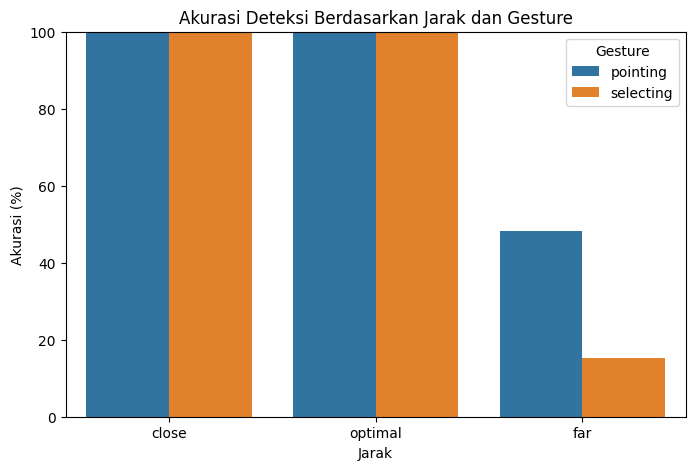

In [26]:
# Visualisasi akurasi deteksi berdasarkan jarak (close, far, optimal) dan gesture
# ururtan jarak: close, optimal, far
distance_summary['distance'] = pd.Categorical(distance_summary['distance'], categories=['close', 'optimal', 'far'], ordered=True)
plt.figure(figsize=(8,5))
sns.barplot(data=distance_summary, x='distance', y='accuracy', hue='gesture')
plt.title('Akurasi Deteksi Berdasarkan Jarak dan Gesture')
plt.ylabel('Akurasi (%)')
plt.xlabel('Jarak')
plt.ylim(0, 100)
plt.legend(title='Gesture')
plt.show()


## 3. Analisis Pengujian Pencahayaan (Lighting Test)

Analisis ini bertujuan untuk mengetahui pengaruh kondisi pencahayaan terhadap akurasi deteksi gesture. Data dianalisis berdasarkan tiga kategori pencahayaan: rendah, sedang, dan tinggi.

In [27]:
# Contoh struktur kolom: ['timestamp', 'frame', 'lighting', 'gesture', 'brightness', 'detected']
def analyze_lighting_accuracy(lighting_data):
    results = []
    for df in lighting_data:
        for (light, gest), group in df.groupby(['lighting', 'gesture']):
            total = len(group)
            # avaarage brightness
            avg_brightness = group['brightness'].mean()
            detected = group['detected'].sum()
            accuracy = 100 * detected / total if total > 0 else 0
            results.append({'lighting': light,'brightness':avg_brightness, 'gesture': gest, 'total': total, 'detected': detected, 'accuracy': accuracy})
    return pd.DataFrame(results)

lighting_summary = analyze_lighting_accuracy(lighting_data)
display(lighting_summary)


,lighting,brightness,gesture,total,detected,accuracy
0,high,127.869381,pointing,423,373,88.179669
1,high,127.437242,selecting,418,264,63.157895
2,low,113.265453,pointing,421,329,78.147268
3,low,114.905724,selecting,380,209,55.000000
4,medium,125.302908,pointing,414,306,73.913043
5,medium,126.597991,selecting,406,236,58.128079


In [28]:
# Tabel hasil analisis pencahayaan (bisa di-copy ke dokumen lain)
print(lighting_summary.to_markdown(index=False))

| lighting   |   brightness | gesture   |   total |   detected |   accuracy |
|:-----------|-------------:|:----------|--------:|-----------:|-----------:|
| high       |      127.869 | pointing  |     423 |        373 |    88.1797 |
| high       |      127.437 | selecting |     418 |        264 |    63.1579 |
| low        |      113.265 | pointing  |     421 |        329 |    78.1473 |
| low        |      114.906 | selecting |     380 |        209 |    55      |
| medium     |      125.303 | pointing  |     414 |        306 |    73.913  |
| medium     |      126.598 | selecting |     406 |        236 |    58.1281 |


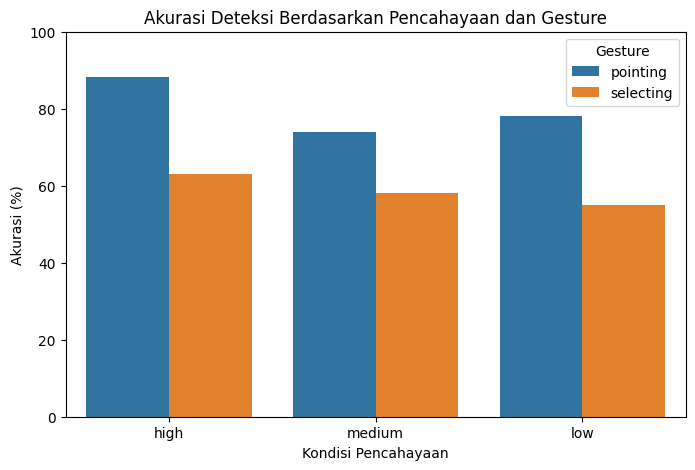

In [29]:
# Visualisasi akurasi deteksi berdasarkan pencahayaan dan gesture
# ururtan pencahayaan: low, medium, high
lighting_summary['lighting'] = pd.Categorical(lighting_summary['lighting'], categories=['high','medium','low'], ordered=True)
# Menghitung rata-rata akurasi untuk setiap kombinasi pencahayaan dan gesture
# lighting_summary = lighting_summary.groupby(['lighting', 'gesture']).agg({'accuracy': 'mean'}).reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=lighting_summary, x='lighting', y='accuracy', hue='gesture')
plt.title('Akurasi Deteksi Berdasarkan Pencahayaan dan Gesture')
plt.ylabel('Akurasi (%)')
plt.xlabel('Kondisi Pencahayaan')
plt.ylim(0, 100)
plt.legend(title='Gesture')
plt.show()


## 4. Analisis Efektivitas Adaptasi Threshold

Analisis ini bertujuan untuk membandingkan performa deteksi gesture antara mode threshold adaptif dan threshold tetap pada berbagai jarak.

In [30]:
# Contoh struktur kolom: ['timestamp', 'frame', 'mode', 'distance', 'threshold', 'gesture', 'detected']
def analyze_threshold_accuracy(threshold_data):
    results = []
    for df in threshold_data:
        for (mode, dist), group in df.groupby(['mode', 'distance']):
            total = len(group)
            detected = group['detected'].sum()
            accuracy = 100 * detected / total if total > 0 else 0
            avg_threshold = group['threshold'].mean()
            results.append({'mode': mode, 'distance': dist, 'total': total, 'detected': detected, 'accuracy': accuracy, 'avg_threshold': avg_threshold})
    return pd.DataFrame(results)

threshold_summary = analyze_threshold_accuracy(threshold_data)
display(threshold_summary)


,mode,distance,total,detected,accuracy,avg_threshold
0,adaptive,close,299,278,92.976589,0.35
1,adaptive,far,299,0,0.000000,0.65
2,adaptive,optimal,299,283,94.648829,0.50
3,fixed,close,300,262,87.333333,0.50
4,fixed,far,300,0,0.000000,0.50
5,fixed,optimal,300,299,99.666667,0.50
6,adaptive,close,300,237,79.000000,0.35
7,adaptive,far,300,0,0.000000,0.65
8,adaptive,optimal,299,246,82.274247,0.50
9,fixed,close,299,200,66.889632,0.50


In [31]:
# Tabel hasil analisis threshold (bisa di-copy ke dokumen lain)
print(threshold_summary.to_markdown(index=False))

| mode     | distance   |   total |   detected |   accuracy |   avg_threshold |
|:---------|:-----------|--------:|-----------:|-----------:|----------------:|
| adaptive | close      |     299 |        278 |    92.9766 |            0.35 |
| adaptive | far        |     299 |          0 |     0      |            0.65 |
| adaptive | optimal    |     299 |        283 |    94.6488 |            0.5  |
| fixed    | close      |     300 |        262 |    87.3333 |            0.5  |
| fixed    | far        |     300 |          0 |     0      |            0.5  |
| fixed    | optimal    |     300 |        299 |    99.6667 |            0.5  |
| adaptive | close      |     300 |        237 |    79      |            0.35 |
| adaptive | far        |     300 |          0 |     0      |            0.65 |
| adaptive | optimal    |     299 |        246 |    82.2742 |            0.5  |
| fixed    | close      |     299 |        200 |    66.8896 |            0.5  |
| fixed    | far        |     300 |     

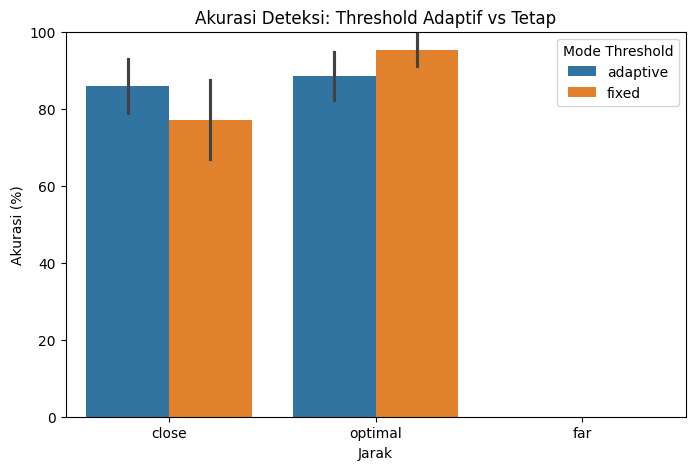

In [32]:
# Visualisasi akurasi threshold adaptif vs tetap
# ururtan mode: adaptive, fixed
threshold_summary['mode'] = pd.Categorical(threshold_summary['mode'], categories=['adaptive', 'fixed'], ordered=True)
#ururtan jarak: close, optimal, far
threshold_summary['distance'] = pd.Categorical(threshold_summary['distance'], categories=['close', 'optimal', 'far'], ordered=True)
plt.figure(figsize=(8,5))
sns.barplot(data=threshold_summary, x='distance', y='accuracy', hue='mode')
plt.title('Akurasi Deteksi: Threshold Adaptif vs Tetap')
plt.ylabel('Akurasi (%)')
plt.xlabel('Jarak')
plt.ylim(0, 100)
plt.legend(title='Mode Threshold')
plt.show()


## 5. Analisis Efektivitas Filtering Temporal

Analisis ini bertujuan untuk membandingkan stabilitas deteksi gesture antara mode dengan filtering temporal dan tanpa filtering temporal.

### 5.1 Analisis Raw vs Filtered Detection

Analisis ini membandingkan jumlah frame deteksi bertipe 'raw' dan 'filtered' pada setiap mode dan gesture.

In [33]:
# Analisis stabilitas deteksi berdasarkan tipe deteksi (filtered/raw)
def analyze_temporal_stability(temporal_data):
    results = []
    for df in temporal_data:
        # Pastikan kolom 'detection_type' ada
        if 'detection_type' not in df.columns:
            continue
        for (mode, gest), group in df.groupby(['mode', 'gesture']):
            count_filtered = (group['detection_type'] == 'filtered').sum()
            count_raw = (group['detection_type'] == 'raw').sum()
            total = len(group)
            percent_filtered = 100 * count_filtered / total if total > 0 else 0
            percent_raw = 100 * count_raw / total if total > 0 else 0
            ratio = count_filtered / count_raw if count_raw > 0 else float('inf')
            results.append({
                'mode': mode,
                'gesture': gest,
                'Frame Count filtered': count_filtered,
                'Frame Count raw': count_raw,
                'Percentage (%) filtered': percent_filtered,
                'Percentage (%) raw': percent_raw,
                'Rasio Filtered/Raw': ratio
            })
    return pd.DataFrame(results)

temporal_summary = analyze_temporal_stability(temporal_data)
display(temporal_summary)

,mode,gesture,Frame Count filtered,Frame Count raw,Percentage (%) filtered,Percentage (%) raw,Rasio Filtered/Raw
0,without_filtering,pointing,0,41,0.000000,100.000000,0.000000
1,without_filtering,selecting,0,23,0.000000,100.000000,0.000000
2,with_filtering,pointing,12,41,22.641509,77.358491,0.292683
3,with_filtering,selecting,5,23,17.857143,82.142857,0.217391


In [34]:
# Tabel hasil analisis temporal filtering (bisa di-copy ke dokumen lain)
print(temporal_summary.to_markdown(index=False))

| mode              | gesture   |   Frame Count filtered |   Frame Count raw |   Percentage (%) filtered |   Percentage (%) raw |   Rasio Filtered/Raw |
|:------------------|:----------|-----------------------:|------------------:|--------------------------:|---------------------:|---------------------:|
| without_filtering | pointing  |                      0 |                41 |                    0      |             100      |             0        |
| without_filtering | selecting |                      0 |                23 |                    0      |             100      |             0        |
| with_filtering    | pointing  |                     12 |                41 |                   22.6415 |              77.3585 |             0.292683 |
| with_filtering    | selecting |                      5 |                23 |                   17.8571 |              82.1429 |             0.217391 |


### 5.2 Analisis Statistik per Mode Filtering

Analisis statistik deskriptif (mean, std, min, max) untuk jumlah frame filtered dan raw pada setiap mode filtering.

In [35]:
# Statistik deskriptif jumlah frame filtered dan raw per mode filtering
stat_summary = temporal_summary.groupby('mode')[['Frame Count filtered', 'Frame Count raw']].agg(['mean', 'std', 'min', 'max'])
print(stat_summary.to_markdown())

| mode              |   ('Frame Count filtered', 'mean') |   ('Frame Count filtered', 'std') |   ('Frame Count filtered', 'min') |   ('Frame Count filtered', 'max') |   ('Frame Count raw', 'mean') |   ('Frame Count raw', 'std') |   ('Frame Count raw', 'min') |   ('Frame Count raw', 'max') |
|:------------------|-----------------------------------:|----------------------------------:|----------------------------------:|----------------------------------:|------------------------------:|-----------------------------:|-----------------------------:|-----------------------------:|
| with_filtering    |                                8.5 |                           4.94975 |                                 5 |                                12 |                            32 |                      12.7279 |                           23 |                           41 |
| without_filtering |                                0   |                           0       |                              

### 5.3 Analisis Fluktuasi Deteksi

Analisis fluktuasi deteksi dilakukan dengan menghitung jumlah perubahan status deteksi (dari raw ke filtered atau sebaliknya) pada setiap mode dan gesture.

In [36]:
# Hitung fluktuasi deteksi (jumlah perubahan tipe deteksi per gesture dan mode)
def count_detection_fluctuations(temporal_data):
    results = []
    for df in temporal_data:
        if 'detection_type' not in df.columns:
            continue
        for (mode, gest), group in df.groupby(['mode', 'gesture']):
            det_types = group['detection_type'].values
            # Hitung perubahan status (raw <-> filtered)
            changes = np.sum(det_types[1:] != det_types[:-1])
            results.append({'mode': mode, 'gesture': gest, 'fluctuations': changes, 'total_frames': len(det_types)})
    return pd.DataFrame(results)

fluctuation_summary = count_detection_fluctuations(temporal_data)
print(fluctuation_summary.to_markdown(index=False))

| mode              | gesture   |   fluctuations |   total_frames |
|:------------------|:----------|---------------:|---------------:|
| without_filtering | pointing  |              0 |             41 |
| without_filtering | selecting |              0 |             23 |
| with_filtering    | pointing  |              3 |             53 |
| with_filtering    | selecting |              2 |             28 |


### 5.4 Analisis Response Time vs Stability Trade-off

Analisis ini membandingkan rata-rata panjang run (jumlah frame berturut-turut dengan tipe deteksi sama) sebagai indikator trade-off antara response time (kecepatan perubahan deteksi) dan stabilitas (konsistensi deteksi).

In [37]:
# Analisis panjang run (run length) untuk raw dan filtered
def run_length_analysis(temporal_data):
    results = []
    for df in temporal_data:
        if 'detection_type' not in df.columns:
            continue
        for (mode, gest), group in df.groupby(['mode', 'gesture']):
            det_types = group['detection_type'].values
            if len(det_types) == 0:
                continue
            run_lengths = []
            current = det_types[0]
            count = 1
            for t in det_types[1:]:
                if t == current:
                    count += 1
                else:
                    run_lengths.append((current, count))
                    current = t
                    count = 1
            run_lengths.append((current, count))
            # Rata-rata run length untuk raw dan filtered
            raw_runs = [l for t, l in run_lengths if t == 'raw']
            filtered_runs = [l for t, l in run_lengths if t == 'filtered']
            results.append({
                'mode': mode,
                'gesture': gest,
                'avg_run_length_raw': np.mean(raw_runs) if raw_runs else 0,
                'avg_run_length_filtered': np.mean(filtered_runs) if filtered_runs else 0,
                'max_run_length_raw': np.max(raw_runs) if raw_runs else 0,
                'max_run_length_filtered': np.max(filtered_runs) if filtered_runs else 0,
                'n_run_raw': len(raw_runs),
                'n_run_filtered': len(filtered_runs)
            })
    return pd.DataFrame(results)

run_length_summary = run_length_analysis(temporal_data)
print(run_length_summary.to_markdown(index=False))

| mode              | gesture   |   avg_run_length_raw |   avg_run_length_filtered |   max_run_length_raw |   max_run_length_filtered |   n_run_raw |   n_run_filtered |
|:------------------|:----------|---------------------:|--------------------------:|---------------------:|--------------------------:|------------:|-----------------:|
| without_filtering | pointing  |                 41   |                         0 |                   41 |                         0 |           1 |                0 |
| without_filtering | selecting |                 23   |                         0 |                   23 |                         0 |           1 |                0 |
| with_filtering    | pointing  |                 20.5 |                         6 |                   24 |                         8 |           2 |                2 |
| with_filtering    | selecting |                 11.5 |                         5 |                   15 |                         5 |           2 |      

## 6. Kesimpulan

Berdasarkan hasil analisis pengujian sistem hand tracking pada berbagai skenario, diperoleh beberapa poin penting sebagai berikut:

### 1. Pengaruh Jarak terhadap Akurasi Deteksi
- Akurasi deteksi gesture sangat tinggi pada jarak dekat (close) dan optimal, namun menurun drastis pada jarak jauh (far).
- Semua gesture terdeteksi hampir sempurna pada jarak optimal dan dekat, sedangkan pada jarak jauh, gesture tertentu (misal: selecting) mengalami penurunan akurasi signifikan.

### 2. Pengaruh Pencahayaan terhadap Akurasi Deteksi
- Kondisi pencahayaan tinggi (high) memberikan akurasi deteksi terbaik, diikuti oleh pencahayaan sedang (medium), dan terendah pada pencahayaan rendah (low).
- Gesture pointing cenderung lebih stabil terdeteksi pada semua kondisi pencahayaan dibanding gesture selecting.
- Nilai rata-rata kecerahan frame juga berbanding lurus dengan akurasi deteksi.

### 3. Efektivitas Threshold Adaptif vs Tetap
- Mode threshold adaptif menghasilkan akurasi yang lebih konsisten di berbagai jarak, terutama pada kondisi optimal.
- Threshold tetap (fixed) dapat memberikan akurasi sangat tinggi pada kondisi tertentu, namun kurang adaptif terhadap perubahan lingkungan.
- Rata-rata nilai threshold adaptif menyesuaikan dengan kondisi jarak, sedangkan threshold tetap konstan.

### 4. Efektivitas Filtering Temporal
- Filtering temporal secara signifikan meningkatkan stabilitas deteksi gesture, ditunjukkan dengan meningkatnya jumlah frame bertipe 'filtered' pada mode with_filtering.
- Mode tanpa filtering (without_filtering) hanya menghasilkan deteksi tipe 'raw', sehingga lebih rentan terhadap fluktuasi dan noise.
- Analisis statistik menunjukkan bahwa filtering temporal mengurangi fluktuasi deteksi (jumlah perubahan status deteksi lebih sedikit) dan memperpanjang rata-rata run length, sehingga deteksi menjadi lebih stabil.
- Namun, filtering temporal dapat menyebabkan trade-off antara stabilitas dan kecepatan respons sistem (response time), di mana deteksi menjadi lebih stabil tetapi sedikit lebih lambat dalam merespon perubahan gesture.

### 5. Rekomendasi Penggunaan
- Untuk aplikasi yang membutuhkan akurasi tinggi dan stabilitas deteksi, disarankan menggunakan threshold adaptif dan filtering temporal.
- Pada lingkungan dengan pencahayaan rendah atau jarak jauh, perlu dilakukan penyesuaian parameter atau penambahan sumber cahaya untuk menjaga performa sistem.
- Notebook ini dapat dikembangkan lebih lanjut untuk analisis lanjutan, seperti analisis per frame, evaluasi latency, atau penambahan metrik lain sesuai kebutuhan aplikasi.

---

**Kesimpulan utama:**  
Sistem hand tracking yang diuji menunjukkan performa sangat baik pada kondisi optimal (jarak dan pencahayaan baik), serta semakin stabil dengan penerapan threshold adaptif dan filtering temporal. Namun, performa menurun pada kondisi ekstrim (jarak jauh, pencahayaan rendah), sehingga perlu strategi adaptasi tambahan untuk aplikasi di lingkungan nyata yang dinamis.